In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division

import seaborn as sns

** Evaluation Metric: RMSE **

```
Important points:

1. in is different from in. ( inches )
2. ft. should be converted to feet
3. cu. should be converted to cubic
4. &amp; should be converted to and
5. x acts as a separator between different dimensions e.g. ( 3 x 4 ), ( 1 x 2 x 3) etc.
6. BTU should be converted to British Thermal Unit
7. OTR should be converted to over the range
8. oz. should be converted to ounces
9. sq. should be converted to square
10. lb. should be converted to pounds
11. / should be converted to by
12. gal. should be converted to gallon
13. mm should be converted to millimeter
```

In [2]:
# load train and test data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
test.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


### We have search term and product title and we need to predict whether the product shown is relevant or not with  1 being non-relevant to 3 being with highly relevant 

```
Methodology:

1. Explore data set
2. Develop notion of relevance
3. Text preprocessing
4. Tokenization
5. Stemming
6. Machine Learning
```

` Note that test set contains both seen and unseen search terms `

** Some utility function for measuring relevance **

In [11]:
def create_set(x):
    x = x.lower() # lowecase string
    x = x.split(' ') # split on empty space will work on clever ways to do this later
    return set(x)

def Dice(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)

    return (2 * len(product_title & search_term)) / (len(product_title) + len(search_term))

def Jaccard(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)
    
    return len(product_title & search_term) / len(product_title | search_term)

def Overlap(row):
    product_title = row['product_title']
    search_term = row['search_term']
    
    product_title = create_set(product_title)
    search_term = create_set(search_term)
    
    return len(product_title & search_term) / min(len(product_title), len(search_term))

In [6]:
train.loc[:, 'dice_relevance'] = train.apply(Dice, axis=1)

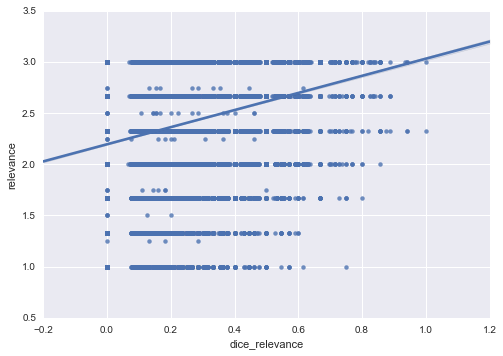

In [9]:
# is there any correlation between releavance and dice_relevance
sns.regplot(x = 'dice_relevance', y = 'relevance', data=train);

In [12]:
train.loc[:, 'jaccard_relevance'] = train.apply(Jaccard, axis=1)

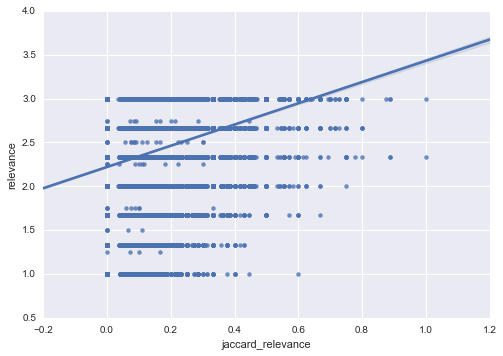

In [13]:
# is there any correlation between releavance and jaccard_relevance
sns.regplot(x = 'jaccard_relevance', y = 'relevance', data=train);

In [14]:
train.loc[:, 'overlap'] = train.apply(Overlap, axis=1)

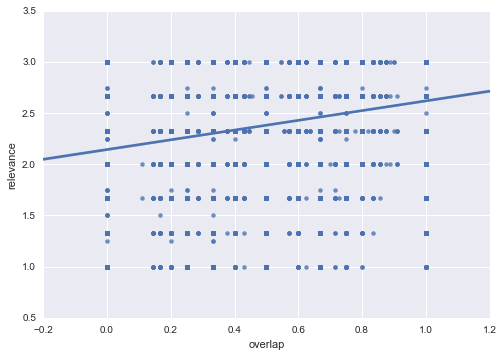

In [15]:
# is there any correlation between releavance and overlap
sns.regplot(x = 'overlap', y = 'relevance', data=train);

In [16]:
from nltk.util import ngrams

In [127]:
def generate_ngrams(sentence, ngram_range=3):
    possible_combinations = []
    for n in range(1, ngram_range + 1):
        ngram_tuples = ngrams(sentence.split(), n)
        for gram in ngram_tuples:
            term = ' '.join(gram)
            possible_combinations.append(term)
    return possible_combinations

def average_dice(row):
    search_term = row['search_term']
    product_title = row['product_title']
    
    product_title = product_title.lower()
    
    search_term_combinations = generate_ngrams(search_term, ngram_range=6) # generate possible combinations
    dice_scores = 0 # keep track of dice score
    product_title_count = len(set(product_title.split(' ')))
    
    for term in search_term_combinations:
        term = term.lower()
        term_words = term.split(' ')
        intersection_count = np.array([1 if w in product_title else 0 for w in term_words]).sum(axis=0)
        dice_scores += ((2 * intersection_count) / (product_title_count + len(set(term_words))))
    
    return dice_scores / 6.

def average_jaccard(row):
    search_term = row['search_term']
    product_title = row['product_title']
    
    product_title = product_title.lower()
    
    search_term_combinations = generate_ngrams(search_term, ngram_range=6) # generate possible combinations
    jaccard_score = 0 # keep track of jaccard score
    product_title_set = set(product_title.split(' '))
    
    for term in search_term_combinations:
        term = term.lower()
        term_words = term.split(' ')
        intersection_count = np.array([1 if w in product_title else 0 for w in term_words]).sum(axis=0)
        jaccard_score += (intersection_count / len(product_title_set |  set(term_words)))
    
    return jaccard_score / 6.


In [125]:
train.loc[:, 'average_dice_score'] = train.apply(average_dice, axis=1)

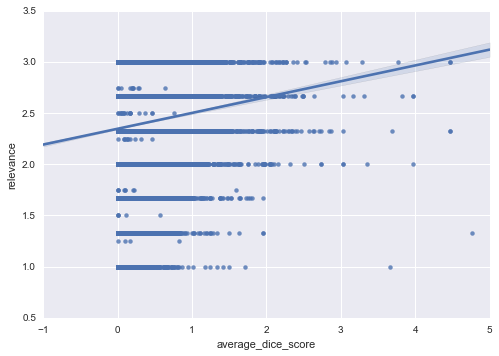

In [126]:
sns.regplot(x = 'average_dice_score', y = 'relevance', data=train);

In [130]:
train.loc[:, 'average_jaccard_score'] = train.apply(average_jaccard, axis=1)

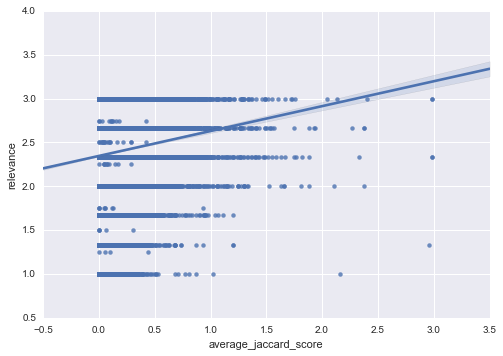

In [131]:
sns.regplot(x = 'average_jaccard_score', y = 'relevance', data=train);

** Analyze text to see if there is need for complicated tokenization, spelling correction etc. **

In [135]:
from nltk import FreqDist

In [142]:
train[['product_title', 'search_term', 'relevance']][:20]

,product_title,search_term,relevance
0,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
5,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00
6,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,2.67
7,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.00
8,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67
9,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.00


In [157]:
FreqDist(' '.join(train.product_title.head(100000).values).split(' ')).most_common(200)

[('in.', 57119),
 ('x', 28050),
 ('ft.', 14821),
 ('in', 14504),
 ('with', 12984),
 ('White', 9198),
 ('and', 8540),
 ('Steel', 4728),
 ('Door', 4620),
 ('4', 4381),
 ('Kit', 4243),
 ('Light', 4111),
 ('Wall', 3989),
 ('Black', 3600),
 ('6', 3599),
 ('12', 3582),
 ('8', 3480),
 ('-', 3273),
 ('2', 3117),
 ('1', 2956),
 ('for', 2917),
 ('Stainless', 2917),
 ('Home', 2900),
 ('Tile', 2776),
 ('Bay', 2403),
 ('3', 2369),
 ('LED', 2357),
 ('Vanity', 2311),
 ('10', 2306),
 ('1/2', 2301),
 ('Bronze', 2238),
 ('Wood', 2227),
 ('24', 2141),
 ('Cabinet', 2133),
 ('5', 2107),
 ('W', 2094),
 ('Top', 2090),
 ('Collection', 2070),
 ('Electric', 2052),
 ('Nickel', 1977),
 ('Gas', 1965),
 ('Hampton', 1908),
 ('36', 1908),
 ('Shower', 1899),
 ('Chrome', 1871),
 ('Paint', 1865),
 ('oz.', 1837),
 ('Outdoor', 1804),
 ('Set', 1801),
 ('cu.', 1785),
 ('sq.', 1784),
 ('Glass', 1773),
 ('3/4', 1766),
 ('Faucet', 1676),
 ('30', 1649),
 ('Vinyl', 1593),
 ('Series', 1567),
 ('Lighting', 1552),
 ('Single', 1466)

## Query Expansion